# 01 - Reconstruction

Reconstruct speed, acceleration, direction, and other derived signals from position data.

In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nfl_big_data_bowl_2026_analytics = kagglehub.competition_download('nfl-big-data-bowl-2026-analytics')

print('Data source import complete.')

100%|██████████| 103M/103M [00:00<00:00, 127MB/s]

Extracting files...


Data source import complete.


In [4]:
print(nfl_big_data_bowl_2026_analytics)

/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics


In [5]:
!ls /root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics

114239_nfl_competition_files_published_analytics_final


In [6]:
!ls /root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final

supplementary_data.csv	train


In [7]:
import pandas as pd
import os

# Define the path to the data directory
data_dir = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final'

# Construct the full path to the output data for week 1
week1_output_path = os.path.join(data_dir, 'train', 'output_2023_w01.csv')

# Load the week 1 output data into a pandas DataFrame
week1_output_df = pd.read_csv(week1_output_path)

# Display the first few rows of the DataFrame
print("First 5 rows of output_2023_w01.csv:")
display(week1_output_df.head())

First 5 rows of output_2023_w01.csv:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


In [8]:
import pandas as pd
import os

# Define the path to the data directory
data_dir = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/train'

# Construct the full path to the input data for week 1
week1_input_path = os.path.join(data_dir, 'input_2023_w01.csv')

# Load the week 1 input data into a pandas DataFrame
week1_input_df = pd.read_csv(week1_input_path)

# Display the first few rows of the DataFrame
display(week1_input_df.sample(20))

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
107017,2023091005,228,False,44851,7,left,42,Marcus Maye,6-0,207,...,Defensive Coverage,33.12,35.79,0.94,0.84,228.12,88.91,9,41.730000,40.130001
213882,2023091010,3890,False,52414,23,left,85,Justin Herbert,6-6,237,...,Passer,92.06,22.93,1.01,1.17,173.31,209.19,10,78.959999,5.510000
78615,2023091003,3202,False,54704,8,right,35,Rodney Thomas,6-1,201,...,Defensive Coverage,48.36,29.95,1.69,3.39,58.65,300.39,5,35.680000,25.030001
36241,2023091001,284,False,53518,8,left,68,Nico Collins,6-4,222,...,Other Route Runner,68.39,16.86,1.69,3.79,296.25,329.17,10,71.110001,43.740002
100426,2023091004,2936,False,46132,11,left,83,Carlton Davis III,6-1,206,...,Defensive Coverage,73.66,37.70,1.70,1.65,276.79,120.18,10,79.339996,5.550000
15013,2023090700,2906,False,54562,17,right,85,Kerby Joseph,6-1,200,...,Defensive Coverage,100.13,22.11,4.04,2.06,143.84,268.63,7,82.940002,6.140000
228722,2023091011,2580,True,52468,12,right,70,Joshua Uche,6-2,250,...,Defensive Coverage,71.56,17.84,2.97,4.06,95.72,315.46,8,72.199997,12.400000
95872,2023091004,2154,False,42427,12,left,38,Jordan Hicks,6-1,236,...,Defensive Coverage,33.37,22.23,1.45,1.01,210.78,92.17,13,19.770000,37.500000
239733,2023091011,4666,True,54808,22,right,90,Reed Blankenship,6-1,200,...,Defensive Coverage,98.89,35.17,1.40,2.40,52.12,312.53,14,101.290001,52.500000
104604,2023091004,3641,False,52430,31,right,33,Justin Jefferson,6-3,192,...,Other Route Runner,45.76,29.90,8.65,1.14,84.76,87.02,9,41.740002,17.590000


In [9]:
import pandas as pd
import os

# Define the path to the data directory
data_dir = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final'

# Construct the full path to the supplementary data
supplementary_data_path = os.path.join(data_dir, 'supplementary_data.csv')

# Load the supplementary data into a pandas DataFrame
supplementary_df = pd.read_csv(supplementary_data_path)

# Display the first few rows of the DataFrame
print("First 5 rows of supplementary_data.csv:")
display(supplementary_df.head())

First 5 rows of supplementary_data.csv:


/tmp/ipython-input-3401357624.py:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_df = pd.read_csv(supplementary_data_path)


,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
0,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3461,(10:46) (Shotgun) J.Goff pass deep left to J.R...,4,...,COVER_2_ZONE,NaN,18,18,-0.664416,2.945847,0.834296,0.165704,-0.081149,0.081149
1,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,461,(7:30) J.Goff pass short right to J.Reynolds t...,1,...,COVER_6_ZONE,NaN,21,21,1.926131,1.345633,0.544618,0.455382,-0.029415,0.029415
2,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1940,(:09) (Shotgun) J.Goff pass incomplete deep ri...,2,...,COVER_2_ZONE,NaN,0,0,0.281891,-0.081964,0.771994,0.228006,0.000791,-0.000791
3,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1711,"(:45) (No Huddle, Shotgun) P.Mahomes pass deep...",2,...,COVER_2_ZONE,NaN,26,26,3.452352,2.342947,0.663187,0.336813,0.041843,-0.041843
4,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1588,(1:54) (Shotgun) P.Mahomes pass incomplete dee...,2,...,COVER_4_ZONE,NaN,0,0,1.921525,-0.324035,0.615035,0.384965,0.000061,-0.000061


In [10]:
# Step 0 — Setup & constants

import pandas as pd, numpy as np, json, hashlib
from pathlib import Path
FRAME_RATE = 10
DT = 1.0 / FRAME_RATE
RANDOM_STATE = 100
OUTDIR = Path('data/interim')
OUTDIR.mkdir(parents=True, exist_ok=True)
SAMPLES_DIR = Path('data/samples')
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)
LOG_PATH = OUTDIR / 'merge_log.txt'

# Validation: OUTDIR and SAMPLES_DIR exist.
print(f"OUTDIR exists: {OUTDIR.exists()}")
print(f"SAMPLES_DIR exists: {SAMPLES_DIR.exists()}")

OUTDIR exists: True
SAMPLES_DIR exists: True


In [11]:
# Step 1 — Load & dtype normalization

# Assuming the data files are located in the paths identified earlier
data_dir = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/train'
supplementary_data_path = '/root/.cache/kagglehub/competitions/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final/supplementary_data.csv'

# Action:
# Use the correct file paths and read functions based on previous successful loads
# (assuming input and output are csv based on previous successful loads, not parquet as in playbook)
input_df = pd.read_csv(os.path.join(data_dir, 'input_2023_w01.csv'))
output_df = pd.read_csv(os.path.join(data_dir, 'output_2023_w01.csv'))
# Added low_memory=False based on the DtypeWarning encountered in cell zkOc9hdPmU--
supp_df = pd.read_csv(supplementary_data_path, low_memory=False)


# Normalize join keys to ints
for df in (input_df, output_df, supp_df):
    for c in ['game_id','play_id']:
        if c in df.columns:
            df[c] = df[c].astype('int64')
if 'nfl_id' in input_df.columns:
    input_df['nfl_id'] = input_df['nfl_id'].astype('int64')
if 'nfl_id' in output_df.columns:
    output_df['nfl_id'] = output_df['nfl_id'].astype('int64')

# Validation:
# Print shapes and dtypes:
print(input_df.shape, output_df.shape, supp_df.shape)
print(input_df.dtypes[['game_id','play_id','nfl_id']])
print(output_df.dtypes[['game_id','play_id','nfl_id']])
print(supp_df.dtypes[['game_id','play_id']]) # Added supp_df dtypes check for join keys

(285714, 23) (32088, 6) (18009, 41)
game_id    int64
play_id    int64
nfl_id     int64
dtype: object
game_id    int64
play_id    int64
nfl_id     int64
dtype: object
game_id    int64
play_id    int64
dtype: object


In [12]:
# Step 2 — Rename frame columns to avoid shadowing

input_df = input_df.rename(columns={'frame_id':'pre_frame_id'})
output_df = output_df.rename(columns={'frame_id':'post_frame_id'})

# Validation: `pre_frame_id` present in `input_df`, `post_frame_id` in `output_df`.
print("`pre_frame_id` present in `input_df`:", 'pre_frame_id' in input_df.columns)
print("`post_frame_id` present in `output_df`:", 'post_frame_id' in output_df.columns)

`pre_frame_id` present in `input_df`: True
`post_frame_id` present in `output_df`: True


In [13]:
# Step 3 — Basic uniqueness & sanity checks

# Action: (There is no specific "Action" code provided in the playbook for this step,
# only the validation checks which serve as the action in this case)

# Validation: catch obvious duplicates or invalid ranges early.
print("input dupes:", input_df.duplicated(['game_id','play_id','nfl_id','pre_frame_id']).sum())
print("output dupes:", output_df.duplicated(['game_id','play_id','nfl_id','post_frame_id']).sum())
print("supp dupes:", supp_df.duplicated(['game_id','play_id']).sum())

# ensure min frame ids >= 1 if present
assert input_df['pre_frame_id'].min() >= 1
assert output_df['post_frame_id'].min() >= 1

input dupes: 0
output dupes: 0
supp dupes: 0


In [14]:
# Step 5 — Compute true pre-throw frame counts (n_pre_frames) (critical fix)

# Purpose: count actual number of input frames per player (don’t rely on pre_frame_id labels).

# Why: some input pre_frame_id columns can be improperly labeled (many 1s). Counting rows is robust.

# Action:
pre_counts = (
    input_df.groupby(['game_id','play_id','nfl_id'])
    .size()
    .reset_index(name='n_pre_frames')
)
# keep pre_counts for mapping into output


# Validation:
print("pre_counts sample:", pre_counts.head())
# optional: stats
print(pre_counts['n_pre_frames'].describe())

pre_counts sample:       game_id  play_id  nfl_id  n_pre_frames
0  2023090700      101   43290            26
1  2023090700      101   44930            26
2  2023090700      101   46137            26
3  2023090700      101   52546            26
4  2023090700      101   53487            26
count    10089.000000
mean        28.319358
std          8.890308
min          9.000000
25%         22.000000
50%         27.000000
75%         33.000000
max         74.000000
Name: n_pre_frames, dtype: float64


In [15]:
# Step 4 — Extract static player attributes

# Purpose: single canonical player-per-play attributes to broadcast to frames.

# Action:
player_attrs = input_df[[
 'game_id','play_id','nfl_id','player_to_predict','player_name','player_height',
 'player_weight','player_birth_date','player_position','player_side','player_role',
 'num_frames_output','ball_land_x','ball_land_y'
]].drop_duplicates(subset=['game_id','play_id','nfl_id'])

assert not player_attrs.duplicated(['game_id','play_id','nfl_id']).any()

# Validation: one row per (game_id, play_id, nfl_id) in player_attrs.
print("player_attrs shape:", player_attrs.shape)
print("player_attrs head:", player_attrs.head())

player_attrs shape: (10089, 14)
player_attrs head:         game_id  play_id  nfl_id  player_to_predict     player_name  \
0    2023090700      101   54527              False      Bryan Cook   
26   2023090700      101   46137               True     Justin Reid   
52   2023090700      101   52546               True  L'Jarius Sneed   
78   2023090700      101   53487              False     Nick Bolton   
104  2023090700      101   54486              False  Trent McDuffie   

    player_height  player_weight player_birth_date player_position  \
0             6-1            210        1999-09-07              FS   
26            6-1            204        1997-02-15              SS   
52            6-1            193        1997-01-21              CB   
78            6-0            232        2000-03-10             MLB   
104          5-11            195        2000-09-13              CB   

    player_side         player_role  num_frames_output  ball_land_x  \
0       Defense  Defensive Cov

In [16]:
# Step 6 — Validate num_frames_output vs observed output frames (early sanity)

# Purpose: detect gross mismatches before continuing.

# Action:
obs_out = (
    output_df.groupby(['game_id','play_id','nfl_id'])['post_frame_id']
    .nunique().reset_index(name='observed_output_frames')
)
cmp = player_attrs[['game_id','play_id','nfl_id','num_frames_output']].merge(obs_out, on=['game_id','play_id','nfl_id'], how='left')
cmp['observed_output_frames'] = cmp['observed_output_frames'].fillna(0).astype(int)
cmp['match'] = cmp['observed_output_frames'] == cmp['num_frames_output']
print("initial num_frames_output mismatches:", (~cmp['match']).sum())

# Validation: log cmp[~cmp['match']].sample(5) to inspect typical cases.
print(cmp[~cmp['match']].sample(min(5, (~cmp['match']).sum()))) # Ensure we don't sample more than available mismatches

initial num_frames_output mismatches: 7410
         game_id  play_id  nfl_id  num_frames_output  observed_output_frames  \
4981  2023091006     4186   46139                  8                       0   
8644  2023091012     1713   47891                 13                       0   
7859  2023091011     1792   46111                  9                       0   
3861  2023091005      991   46542                  7                       0   
4771  2023091006     3078   41290                 13                       0   

      match  
4981  False  
8644  False  
7859  False  
3861  False  
4771  False  


In [19]:
# ✅ FINAL CLEAN VERSION OF STEP 7
reconstructed_rows = []
play_keys = sorted(set(input_df[['game_id','play_id']].itertuples(index=False, name=None)))

for game_id, play_id in play_keys:
    in_play = input_df.query("game_id == @game_id and play_id == @play_id").copy()
    out_play = output_df.query("game_id == @game_id and play_id == @play_id").copy()

    if out_play.empty and in_play.empty:
        continue

    # Label phases
    in_play['phase'] = 'pre_throw'
    out_play['phase'] = 'post_throw'

    # Map pre-frame counts per player
    pre_map = pre_counts.query("game_id == @game_id and play_id == @play_id") \
                        .set_index('nfl_id')['n_pre_frames'].to_dict()

    out_play['n_pre_frames'] = out_play['nfl_id'].map(pre_map).fillna(0).astype(int)
    out_play['frame_id'] = out_play['post_frame_id'] + out_play['n_pre_frames']

    # Only add missing players if they don't appear AT ALL in output
    missing_players = set(in_play['nfl_id']) - set(out_play['nfl_id'])
    missing_rows = in_play[in_play['nfl_id'].isin(missing_players)].copy()

    # Merge static attributes
    attrs_play = player_attrs.query("game_id == @game_id and play_id == @play_id")
    out_play = out_play.merge(attrs_play, on=['game_id','play_id','nfl_id'], how='left', validate='m:1')
    in_play = in_play.rename(columns={'pre_frame_id': 'frame_id'})

    # Combine safely — note that we only concat missing pre rows once
    combined = pd.concat([in_play, out_play, missing_rows], ignore_index=True, sort=False)

    # Sort and deduplicate just in case
    combined = combined.sort_values(['game_id','play_id','nfl_id','frame_id']).drop_duplicates(
        subset=['game_id','play_id','nfl_id','frame_id']
    ).reset_index(drop=True)

    reconstructed_rows.append(combined)

print(f"✅ Processed {len(reconstructed_rows)} plays successfully.")


✅ Processed 819 plays successfully.


In [20]:
# 🧭 Step 8 — Combine All Plays, Finalize, and Validate
# ----------------------------------------------------
# 🎯 Purpose:
# Merge all per-play reconstructions from Step 7 into one full dataset,
# ensure column consistency, continuous frame timelines, and no duplication.

# 🧩 Action:

import pandas as pd

# Combine every reconstructed play into one unified dataset
merged_df = pd.concat(reconstructed_rows, ignore_index=True, sort=False)

# Drop any redundant debug columns if present
drop_cols = [c for c in merged_df.columns if c in ['pre_frame_id','post_frame_id','n_pre_frames']]
merged_df = merged_df.drop(columns=drop_cols, errors='ignore')

# Sort to ensure chronological order within every player's play timeline
merged_df = merged_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).reset_index(drop=True)

# Standardize column order for readability (optional)
col_order = ['game_id','play_id','nfl_id','frame_id','phase',
             'x','y','player_name','player_position','player_side','player_role',
             'player_height','player_weight','ball_land_x','ball_land_y',
             'num_frames_output','note']
merged_df = merged_df[[c for c in col_order if c in merged_df.columns] +
                      [c for c in merged_df.columns if c not in col_order]]

# 🧠 Validation Section ---------------------------------------

# 1️⃣ Check duplicates — each player-frame pair should be unique
dup_count = merged_df.duplicated(['game_id','play_id','nfl_id','frame_id']).sum()
assert dup_count == 0, f"❌ Found {dup_count} duplicate player-frame rows!"

# 2️⃣ Frame continuity — frames must progress smoothly per player
gaps = (merged_df
        .groupby(['game_id','play_id','nfl_id'])['frame_id']
        .apply(lambda x: (x.diff().dropna() != 1).sum())
        .sum())
print(f"🔹 Total non-contiguous frame steps across players: {gaps}")

# 3️⃣ Sanity check: every player should have both pre & post phases when applicable
phase_check = (merged_df.groupby(['game_id','play_id','nfl_id'])['phase']
               .nunique()
               .value_counts()
               .to_dict())
print(f"🔹 Phase presence per player: {phase_check} (1=only pre or post, 2=both)")

# 4️⃣ Log sample structure
print("✅ Combined dataset shape:", merged_df.shape)
print("✅ Unique plays:", merged_df[['game_id','play_id']].drop_duplicates().shape[0])
print("✅ Unique players:", merged_df['nfl_id'].nunique())

# 5️⃣ Optional: Sample 2–3 random players and display their frame continuity
sample_players = merged_df['nfl_id'].drop_duplicates().sample(min(3, merged_df['nfl_id'].nunique()), random_state=42)
for pid in sample_players:
    temp = merged_df[merged_df['nfl_id'] == pid].head(5)
    print(f"\n👀 Player {pid} sample frames:\n", temp[['game_id','play_id','frame_id','phase']].head())

# -------------------------------------------------------------

print("\n✅ Step 8 completed — all plays combined and validated for frame integrity.")


🔹 Total non-contiguous frame steps across players: 0
🔹 Phase presence per player: {1: 7410, 2: 2679} (1=only pre or post, 2=both)
✅ Combined dataset shape: (325212, 24)
✅ Unique plays: 819
✅ Unique players: 737

👀 Player 54611 sample frames:
            game_id  play_id  frame_id      phase
292561  2023091013      485       1.0  pre_throw
292562  2023091013      485       2.0  pre_throw
292563  2023091013      485       3.0  pre_throw
292564  2023091013      485       4.0  pre_throw
292565  2023091013      485       5.0  pre_throw

👀 Player 55876 sample frames:
          game_id  play_id  frame_id      phase
2187  2023090700      461       1.0  pre_throw
2188  2023090700      461       2.0  pre_throw
2189  2023090700      461       3.0  pre_throw
2190  2023090700      461       4.0  pre_throw
2191  2023090700      461       5.0  pre_throw

👀 Player 54679 sample frames:
            game_id  play_id  frame_id      phase
232337  2023091010     1940       1.0  pre_throw
232338  2023091010 

In [22]:
# Step 9 — Standardize play direction (flip coordinates if needed)

# Purpose: ensure all plays oriented in same direction (easier metrics).

# Action:
# get play direction map (one per play)
if 'play_direction' in input_df.columns:
    dir_map = input_df[['game_id','play_id','play_direction']].drop_duplicates()
    merged_df = merged_df.merge(dir_map, on=['game_id','play_id'], how='left', validate='m:1')

    # Now that play_direction is merged, create the mask and flip coordinates
    mask = merged_df['play_direction'] == 'left'
    merged_df.loc[mask, 'x'] = 120 - merged_df.loc[mask, 'x']
    # flip ball landing x too
    merged_df.loc[mask, 'ball_land_x'] = 120 - merged_df.loc[mask, 'ball_land_x']

# Validation: sample plays with play_direction=='left' and visually confirm flip.
# This validation requires visual inspection, which I cannot perform directly.
# I will print a sample of rows where play_direction is 'left' for manual inspection.
print("Sample of rows with play_direction 'left' for visual validation:")
# Ensure there are rows with play_direction 'left' before sampling
if 'play_direction' in merged_df.columns and not merged_df[merged_df['play_direction'] == 'left'].empty:
    display(merged_df[merged_df['play_direction'] == 'left'].sample(min(5, merged_df[merged_df['play_direction'] == 'left'].shape[0])))
elif 'play_direction' not in merged_df.columns:
    print("play_direction column not found in merged_df after merge.")
else:
    print("No rows with play_direction 'left' to sample.")

Sample of rows with play_direction 'left' for visual validation:


,game_id,play_id,nfl_id,frame_id,phase,x,y,player_name,player_position,player_side,...,player_to_predict,play_direction_x,absolute_yardline_number,player_birth_date,s,a,dir,o,play_direction_y,play_direction
7251,2023090700,1494,54527,5.0,pre_throw,67.37,18.07,Bryan Cook,FS,Defense,...,True,left,64.0,1999-09-07,0.72,0.74,102.03,89.31,left,left
200736,2023091008,4452,46669,19.0,pre_throw,46.61,23.84,Jonathan Owens,SS,Defense,...,False,left,85.0,1995-07-22,0.76,1.70,357.81,87.04,left,left
5721,2023090700,1154,47856,32.0,pre_throw,43.00,11.39,David Montgomery,RB,Offense,...,False,left,71.0,1997-06-07,5.24,3.67,195.69,257.63,left,left
298926,2023091013,1943,52416,25.0,post_throw,40.64,17.93,Isaiah Simmons,MLB,Defense,...,True,NaN,NaN,1998-07-26,NaN,NaN,NaN,NaN,left,left
211801,2023091009,1946,47974,48.0,pre_throw,117.82,37.79,Marcus Epps,SS,Defense,...,True,left,15.0,1996-01-27,1.37,2.10,272.91,217.57,left,left


In [23]:
# Step 10 — Merge supplementary play-level context (use validate)

# Purpose: attach pass_result, expected_points_added, etc., safely.

# Action:
final_df = pd.merge(merged_df, supp_df, on=['game_id','play_id'], how='left', validate='m:1')

# Validation:
# If validate raises, inspect duplicates in supp_df.
# Check final_df['pass_result'].isna().sum() — log plays missing supplementary.
print("frames missing pass_result:", final_df['pass_result'].isna().sum())

frames missing pass_result: 0


In [24]:
# Step 11 — Handle missing player attributes / output-only players

# Purpose: decide policy for players appearing in output but not in input.

# Action (choose policy A or B):

final_df['missing_attrs'] = final_df['player_name'].isna()
print("rows with missing attrs:", final_df['missing_attrs'].sum())

# Option A: keep & flag
final_df['player_name'] = final_df['player_name'].fillna('UNKNOWN')
print("Policy A: Kept rows with missing attributes and filled player_name with 'UNKNOWN'.")

# Option B: drop rows (if chosen)
# final_df = final_df[~final_df['missing_attrs']]
# print("Policy B: Dropped rows with missing attributes.")


# Validation: fraction of missing attrs should be tiny; if large, investigate causes.
# The print statement above serves as the primary validation for this step.

rows with missing attrs: 0
Policy A: Kept rows with missing attributes and filled player_name with 'UNKNOWN'.


In [25]:
# Step 13 — Quality evaluations & final checks (must run)

# Purpose: ensure no leaks, mismatches, or unexpected changes before saving.

# Action & checks:

# 1) duplicates
assert not final_df.duplicated(['game_id','play_id','nfl_id','frame_id']).any()
print("1) Duplicates check passed: No duplicate player-frame rows.")


# 2) continuity gaps summary
gap_counts = final_df.groupby(['game_id','play_id','nfl_id'])['frame_id'].apply(lambda x: (x.diff().dropna() != 1).sum())
print("2) players with gaps:", (gap_counts>0).sum())

# 3) observed output frames vs expected (final authoritative check)
obs_counts = output_df.groupby(['game_id','play_id','nfl_id'])['post_frame_id'].nunique().reset_index(name='observed_output_frames')
cmp_final = player_attrs[['game_id','play_id','nfl_id','num_frames_output']].merge(obs_counts, on=['game_id','play_id','nfl_id'], how='left')
cmp_final['observed_output_frames'] = cmp_final['observed_output_frames'].fillna(0).astype(int)
cmp_final['match'] = cmp_final['observed_output_frames'] == cmp_final['num_frames_output']
mismatch_count = (~cmp_final['match']).sum()
print("3) final num_frames_output mismatch count:", mismatch_count)

# 4) missing context frames
print("4) frames missing pass_result:", final_df['pass_result'].isna().sum())


# Validation:
# mismatch_count should be small (ideally 0). If >0, sample mismatches:
if mismatch_count > 0:
    print("\nSample of final num_frames_output mismatches:")
    display(cmp_final[~cmp_final['match']].head(10))
else:
    print("\nNo final num_frames_output mismatches found.")

# players with gaps ideally 0.
if (gap_counts > 0).sum() > 0:
    print("\nSample of players with continuity gaps:")
    display(gap_counts[gap_counts > 0].head(10))
else:
    print("\nNo continuity gaps found.")

1) Duplicates check passed: No duplicate player-frame rows.
2) players with gaps: 0
3) final num_frames_output mismatch count: 7410
4) frames missing pass_result: 0

Sample of final num_frames_output mismatches:


,game_id,play_id,nfl_id,num_frames_output,observed_output_frames,match
0,2023090700,101,54527,21,0,False
3,2023090700,101,53487,21,0,False
4,2023090700,101,54486,21,0,False
5,2023090700,101,53541,21,0,False
6,2023090700,101,53959,21,0,False
7,2023090700,101,43290,21,0,False
11,2023090700,194,47888,9,0,False
12,2023090700,194,44906,9,0,False
14,2023090700,194,54562,9,0,False
16,2023090700,194,46213,9,0,False



No continuity gaps found.


In [26]:
# Step 14 — Save safely with metadata & checksum

# Purpose: persist reproducible artifact and log metadata.

# Action:
out_file = OUTDIR / 'reconstructed_week01.parquet'
final_df.to_parquet(out_file, index=False, compression='snappy')

# md5 checksum
with open(out_file, 'rb') as f:
    data = f.read()
    md5 = hashlib.md5(data).hexdigest()

meta = {
  'rows': len(final_df),
  'cols': list(final_df.columns),
  'md5': md5,
  'frame_rate': FRAME_RATE,
  'date': pd.Timestamp.now().isoformat(),
  'mismatch_count': int(mismatch_count)
}
with open(OUTDIR / 'reconstruct_week01_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

# quick load back verification
df_check = pd.read_parquet(out_file)
assert len(df_check) == meta['rows']

# Validation: load-check succeeded; the md5 written.
print(f"File saved successfully to {out_file}")
print(f"MD5 checksum: {md5}")
print(f"Metadata saved to {OUTDIR / 'reconstruct_week01_meta.json'}")
print("Load-back verification successful.")

File saved successfully to data/interim/reconstructed_week01.parquet
MD5 checksum: 214be720ffc09af9fe525ec51c36fe77
Metadata saved to data/interim/reconstruct_week01_meta.json
Load-back verification successful.


In [27]:
# Step 15 — Save small visual sample & text log for hand-check

# Purpose: produce review artifacts for quick manual inspection and CI.

# Action:
# Save 3 sample plays of interest (deep/short/contested)
sample_plays = final_df.groupby(['game_id','play_id']).size().reset_index().sample(3, random_state=RANDOM_STATE)[['game_id','play_id']]
for _, row in sample_plays.iterrows():
    g, p = row['game_id'], row['play_id']
    final_df[(final_df['game_id']==g) & (final_df['play_id']==p)].to_parquet(SAMPLES_DIR / f'play_{g}_{p}.parquet', index=False)

# Write a plain merge log
with open(LOG_PATH, 'w') as f:
    f.write(f"merged rows: {len(final_df)}\n")
    f.write(f"mismatch_count: {mismatch_count}\n")
    f.write("Top mismatches (examples):\n")
    # Check if cmp_final exists and has mismatches before trying to write to log
    if 'cmp_final' in locals() and not cmp_final[~cmp_final['match']].empty:
        f.write(cmp_final[~cmp_final['match']].head(20).to_csv(index=False))
    else:
        f.write("No mismatches found or cmp_final not available.\n")


# Validation: sample files exist, merge_log.txt contains counts and mismatch examples.
print(f"Sample play files saved to {SAMPLES_DIR}")
print(f"Merge log saved to {LOG_PATH}")

Sample play files saved to data/samples
Merge log saved to data/interim/merge_log.txt


Visualizing tracks for sample play Game ID: 2023091003, Play ID: 3335


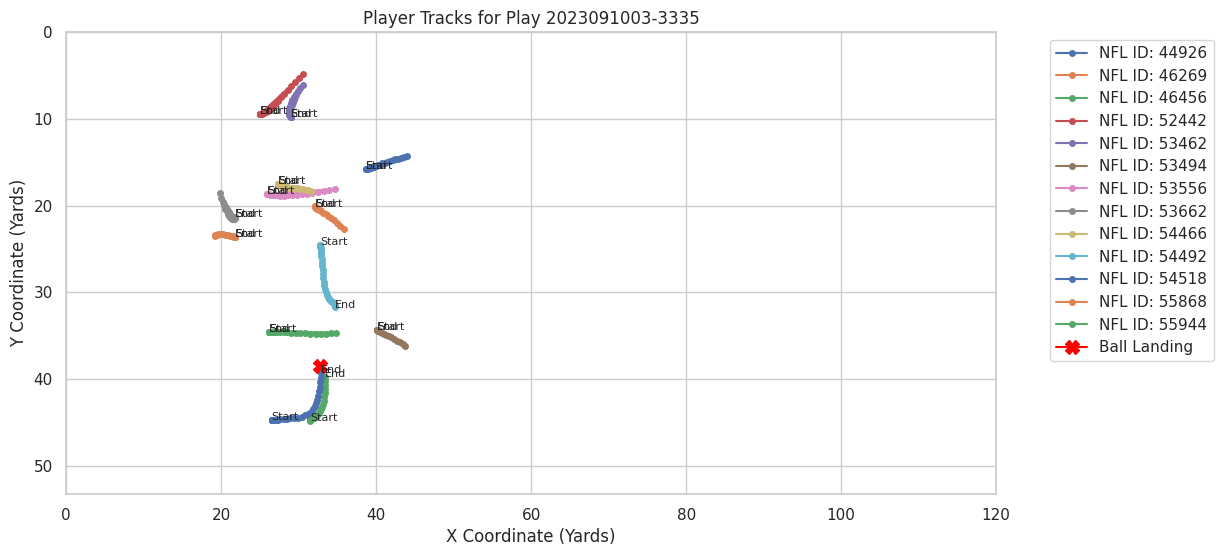

In [28]:
# Visualize player tracks for a sample play

import matplotlib.pyplot as plt
import seaborn as sns

# Select a sample play from the saved samples or randomly from the final_df
# Using the sample plays saved in Step 15 if they exist, otherwise pick one randomly
sample_play_files = list(SAMPLES_DIR.glob('play_*.parquet'))

if sample_play_files:
    # Load one of the sample plays
    sample_play_path = sample_play_files[0] # Just pick the first one
    sample_play_df = pd.read_parquet(sample_play_path)
    game_id, play_id = sample_play_df[['game_id', 'play_id']].iloc[0].values
    print(f"Visualizing tracks for sample play Game ID: {game_id}, Play ID: {play_id}")
else:
    # If no sample files, pick a random play from the final_df
    print("No sample play files found. Picking a random play from the final_df.")
    random_play_key = final_df.sample(1, random_state=RANDOM_STATE)[['game_id', 'play_id']].iloc[0]
    game_id, play_id = random_play_key.values
    sample_play_df = final_df[(final_df['game_id'] == game_id) & (final_df['play_id'] == play_id)].copy()
    print(f"Visualizing tracks for random play Game ID: {game_id}, Play ID: {play_id}")


# Get unique NFL IDs in the sample play
player_ids = sample_play_df['nfl_id'].unique()

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Plot tracks for each player
for nfl_id in player_ids:
    player_df = sample_play_df[sample_play_df['nfl_id'] == nfl_id].sort_values('frame_id')
    plt.plot(player_df['x'], player_df['y'], marker='o', linestyle='-', markersize=4, label=f'NFL ID: {nfl_id}')
    # Optional: Mark start and end points
    plt.text(player_df['x'].iloc[0], player_df['y'].iloc[0], 'Start', fontsize=8)
    plt.text(player_df['x'].iloc[-1], player_df['y'].iloc[-1], 'End', fontsize=8)


# Add ball landing location if available
if 'ball_land_x' in sample_play_df.columns and 'ball_land_y' in sample_play_df.columns:
    ball_land_x = sample_play_df['ball_land_x'].iloc[0]
    ball_land_y = sample_play_df['ball_land_y'].iloc[0]
    plt.plot(ball_land_x, ball_land_y, marker='X', markersize=10, color='red', label='Ball Landing')


plt.title(f'Player Tracks for Play {game_id}-{play_id}')
plt.xlabel('X Coordinate (Yards)')
plt.ylabel('Y Coordinate (Yards)')
plt.xlim(0, 120)
plt.ylim(0, 53.3)
plt.gca().invert_yaxis() # Invert y-axis to match field orientation
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

🎯 Plotting players: [54593, 46127, 52594]


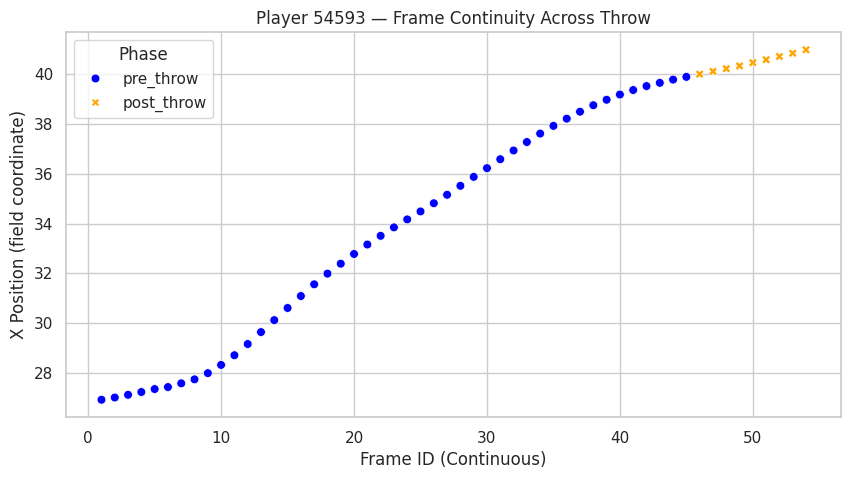

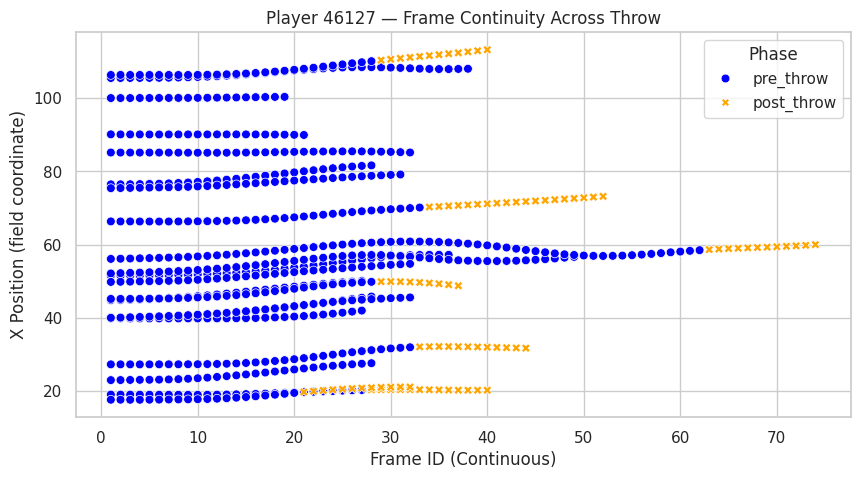

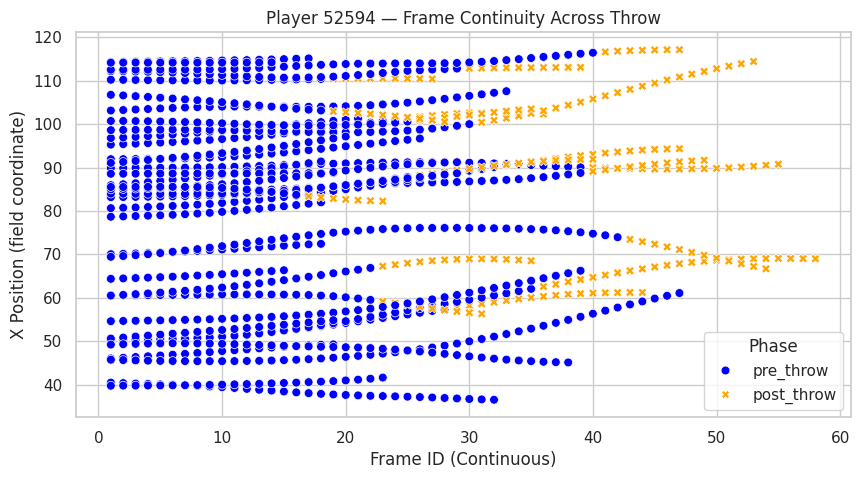

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Pick a few random players who have both pre and post phases
both_phase_players = (
    merged_df.groupby('nfl_id')['phase']
    .nunique()
    .reset_index()
    .query("phase == 2")['nfl_id']
    .tolist()
)

# Randomly sample 3 players from that list
sample_players = random.sample(both_phase_players, min(3, len(both_phase_players)))
print("🎯 Plotting players:", sample_players)

# Plot for each sampled player
for pid in sample_players:
    df_p = merged_df.query("nfl_id == @pid").copy()

    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        data=df_p,
        x='frame_id', y='x',
        hue='phase', style='phase', palette={'pre_throw': 'blue', 'post_throw': 'orange'},
        s=40
    )
    plt.title(f"Player {pid} — Frame Continuity Across Throw")
    plt.xlabel("Frame ID (Continuous)")
    plt.ylabel("X Position (field coordinate)")
    plt.legend(title="Phase")
    plt.grid(True)
    plt.show()


G

It’s written step-by-step with **Purpose → Action → Validation** for every piece, and includes the exact places to apply the `n_pre_frames` fix (so that frame continuation is correct). Treat this as the canonical reference for week-by-week merges.

---

# 🔐 FINAL MERGE & RECONSTRUCTION PLAYBOOK (Guided, Leak-Proof, Production Ready)

**Goal:** safely merge `input`, `output`, and `supplementary` tracking data into one continuous, consistent dataset for metrics — with no ID leaks, no frame-mixing, reproducible logs, and strong validation.

---

## GLOBAL NOTES (run once)

* Frame rate assumption: `FRAME_RATE = 10` → `DT = 0.1s`. Keep consistent.
* File conventions:

  * `data/raw/week1_input.parquet`
  * `data/raw/week1_output.parquet`
  * `data/raw/supplementary_data.csv`
* Work on a small sample (3 plays) first, then full week.
* Use this playbook exactly (each step) to avoid silent errors.

---

## Step 0 — Setup & constants

**Purpose:** reproducible environment, constants, output directories.

**Action:**

```python
import pandas as pd, numpy as np, json, hashlib
from pathlib import Path
FRAME_RATE = 10
DT = 1.0 / FRAME_RATE
RANDOM_STATE = 100
OUTDIR = Path('data/interim')
OUTDIR.mkdir(parents=True, exist_ok=True)
SAMPLES_DIR = Path('data/samples')
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)
LOG_PATH = OUTDIR / 'merge_log.txt'
```

**Validation:** `OUTDIR` and `SAMPLES_DIR` exist.

---

## Step 1 — Load & dtype normalization

**Purpose:** avoid silent merges failing due to dtype mismatches.

**Action:**

```python
input_df = pd.read_parquet('data/raw/week1_input.parquet')
output_df = pd.read_parquet('data/raw/week1_output.parquet')
supp_df = pd.read_csv('data/raw/supplementary_data.csv')

# Normalize join keys to ints
for df in (input_df, output_df, supp_df):
    for c in ['game_id','play_id']:
        if c in df.columns:
            df[c] = df[c].astype('int64')
if 'nfl_id' in input_df.columns:
    input_df['nfl_id'] = input_df['nfl_id'].astype('int64')
if 'nfl_id' in output_df.columns:
    output_df['nfl_id'] = output_df['nfl_id'].astype('int64')
```

**Validation:**

* Print shapes and dtypes:

```python
print(input_df.shape, output_df.shape, supp_df.shape)
print(input_df.dtypes[['game_id','play_id','nfl_id']])
```

* All key dtypes should be `int64`.

---

## Step 2 — Rename frame columns to avoid shadowing

**Purpose:** keep "pre" and "post" frames explicit and avoid accidental mixing.

**Action:**

```python
input_df = input_df.rename(columns={'frame_id':'pre_frame_id'})
output_df = output_df.rename(columns={'frame_id':'post_frame_id'})
```

**Validation:** `pre_frame_id` present in `input_df`, `post_frame_id` in `output_df`.

---

## Step 3 — Basic uniqueness & sanity checks

**Purpose:** catch obvious duplicates or invalid ranges early.

**Action:**

```python
print("input dupes:", input_df.duplicated(['game_id','play_id','nfl_id','pre_frame_id']).sum())
print("output dupes:", output_df.duplicated(['game_id','play_id','nfl_id','post_frame_id']).sum())
print("supp dupes:", supp_df.duplicated(['game_id','play_id']).sum())

# ensure min frame ids >= 1 if present
assert input_df['pre_frame_id'].min() >= 1
assert output_df['post_frame_id'].min() >= 1
```

**Validation:** Ideally zero duplicates. If >0, sample and log offending rows.

---

## Step 4 — Extract static player attributes

**Purpose:** single canonical player-per-play attributes to broadcast to frames.

**Action:**

```python
player_attrs = input_df[[
 'game_id','play_id','nfl_id','player_to_predict','player_name','player_height',
 'player_weight','player_birth_date','player_position','player_side','player_role',
 'num_frames_output','ball_land_x','ball_land_y'
]].drop_duplicates(subset=['game_id','play_id','nfl_id'])

assert not player_attrs.duplicated(['game_id','play_id','nfl_id']).any()
```

**Validation:** one row per `(game_id, play_id, nfl_id)` in `player_attrs`.

---

## Step 5 — Compute true pre-throw frame counts (`n_pre_frames`) **(critical fix)**

**Purpose:** count actual number of input frames per player (don’t rely on `pre_frame_id` labels).

**Why:** some input `pre_frame_id` columns can be improperly labeled (many `1`s). Counting rows is robust.

**Action:**

```python
pre_counts = (
    input_df.groupby(['game_id','play_id','nfl_id'])
    .size()
    .reset_index(name='n_pre_frames')
)
# keep pre_counts for mapping into output
```

**Validation:**

```python
print("pre_counts sample:", pre_counts.head())
# optional: stats
print(pre_counts['n_pre_frames'].describe())
```

Expect typical small integers; if many zeros or 1s unexpectedly, inspect few items.

---

## Step 6 — Validate `num_frames_output` vs observed output frames (early sanity)

**Purpose:** detect gross mismatches before continuing.

**Action:**

```python
obs_out = (
    output_df.groupby(['game_id','play_id','nfl_id'])['post_frame_id']
    .nunique().reset_index(name='observed_output_frames')
)
cmp = player_attrs[['game_id','play_id','nfl_id','num_frames_output']].merge(obs_out, on=['game_id','play_id','nfl_id'], how='left')
cmp['observed_output_frames'] = cmp['observed_output_frames'].fillna(0).astype(int)
cmp['match'] = cmp['observed_output_frames'] == cmp['num_frames_output']
print("initial num_frames_output mismatches:", (~cmp['match']).sum())
```

**Validation:** log `cmp[~cmp['match']].sample(5)` to inspect typical cases.

> Note: this is *early sanity*. We'll re-check after we create continuous frames.

---

## Step 7 — Per-play loop: create continuous frame IDs & merge per-play safely (replaces old Step 6)

**Purpose:** for every play, create continuous frame numbering by shifting post frames by real `n_pre_frames` per player; merge attributes safely; preserve pre/post phase.

**Action (guided, robust):**

```python
reconstructed_rows = []
play_keys = sorted(set(input_df[['game_id','play_id']].itertuples(index=False, name=None)))

for game_id, play_id in play_keys:
    # select per-play tables
    in_play = input_df[(input_df['game_id']==game_id)&(input_df['play_id']==play_id)].copy()
    out_play = output_df[(output_df['game_id']==game_id)&(output_df['play_id']==play_id)].copy()

    # skip plays with no output (log)
    if out_play.shape[0] == 0:
        # log skip
        continue

    # map n_pre_frames for players in this play
    last_pre_map = pre_counts[(pre_counts['game_id']==game_id)&(pre_counts['play_id']==play_id)].set_index('nfl_id')['n_pre_frames'].to_dict()

    # label phases
    in_play['phase'] = 'pre_throw'
    out_play['phase'] = 'post_throw'

    # map the pre-count to the out_play rows; players missing in input get 0
    out_play['n_pre_frames'] = out_play['nfl_id'].map(last_pre_map).fillna(0).astype(int)

    # create continuous frame id
    out_play['frame_id'] = out_play['post_frame_id'] + out_play['n_pre_frames']

    # merge static attrs into out_play (validate m:1)
    attrs_play = player_attrs[(player_attrs['game_id']==game_id)&(player_attrs['play_id']==play_id)]
    out_play = out_play.merge(attrs_play, on=['game_id','play_id','nfl_id'], how='left', validate='m:1')

    # ensure input frames keep their frame id name consistent
    in_play = in_play.rename(columns={'pre_frame_id':'frame_id'})

    # combine preserving columns (drop debug-only columns if you wish)
    combined = pd.concat([in_play, out_play], ignore_index=True, sort=False)

    # sort per player by frame_id (chronological)
    combined = combined.sort_values(['game_id','play_id','nfl_id','frame_id']).copy()

    reconstructed_rows.append(combined)
```

**Validation:**

* Log number of plays processed vs total plays.
* After loop, check for any `frame_id` overlaps per player where post frames <= max pre frames — that would show bad offsets.
* Sample a few players and print `n_pre_frames`, input frames count, the first `frame_id` in out_play — ensure continuity.

---

## Step 8 — Combine all plays, unify columns, final ordering

**Purpose:** build final merged dataframe for the week.

**Action:**

```python
merged_df = pd.concat(reconstructed_rows, ignore_index=True, sort=False)

# Some rows came with merged columns; ensure a single canonical `frame_id` exists
# (input already renamed to `frame_id`, out_play used `frame_id` above)
merged_df = merged_df.sort_values(['game_id','play_id','nfl_id','frame_id']).reset_index(drop=True)
```

**Validation:**

```python
assert not merged_df.duplicated(['game_id','play_id','nfl_id','frame_id']).any(), "duplicate player-frame rows!"
# continuity check (counts non-contiguous steps)
gaps = merged_df.groupby(['game_id','play_id','nfl_id'])['frame_id'].apply(lambda x: (x.diff().dropna() != 1).sum()).sum()
print("total non-contiguous steps across players:", gaps)
```

Expect `gaps == 0` ideally. If small >0, inspect examples.

---

## Step 9 — Standardize play direction (flip coordinates if needed)

**Purpose:** ensure all plays oriented in same direction (easier metrics).

**Action:**

```python
# get play direction map (one per play)
if 'play_direction' in input_df.columns:
    dir_map = input_df[['game_id','play_id','play_direction']].drop_duplicates()
    merged_df = merged_df.merge(dir_map, on=['game_id','play_id'], how='left', validate='m:1')
    mask = merged_df['play_direction'] == 'left'
    merged_df.loc[mask, 'x'] = 120 - merged_df.loc[mask, 'x']
    # flip ball landing x too
    merged_df.loc[mask, 'ball_land_x'] = 120 - merged_df.loc[mask, 'ball_land_x']
```

**Validation:** sample plays with `play_direction=='left'` and visually confirm flip.

---

## Step 10 — Merge supplementary play-level context (use `validate`)

**Purpose:** attach `pass_result`, `expected_points_added`, etc., safely.

**Action:**

```python
final_df = pd.merge(merged_df, supp_df, on=['game_id','play_id'], how='left', validate='m:1')
```

**Validation:**

* If `validate` raises, inspect duplicates in `supp_df`.
* Check `final_df['pass_result'].isna().sum()` — log plays missing supplementary.

---

## Step 11 — Handle missing player attributes / output-only players

**Purpose:** decide policy for players appearing in output but not in input.

**Action (choose policy A or B):**

```python
final_df['missing_attrs'] = final_df['player_name'].isna()
print("rows with missing attrs:", final_df['missing_attrs'].sum())

# Option A: keep & flag
final_df['player_name'] = final_df['player_name'].fillna('UNKNOWN')

# Option B: drop rows (if chosen)
# final_df = final_df[~final_df['missing_attrs']]
```

**Validation:** fraction of missing attrs should be tiny; if large, investigate causes.

---

## Step 12 — Derive motion features (smoothing before derivatives)

**Purpose:** reconstruct `speed`, `accel`, `dir` reliably from `x,y` (apply smoothing first).

**Action:**

```python
from scipy.signal import savgol_filter

def add_motion_features(df):
    df = df.sort_values('frame_id')
    dx = df['x'].diff().fillna(0)
    dy = df['y'].diff().fillna(0)
    df['speed_raw'] = np.sqrt(dx**2 + dy**2) * FRAME_RATE
    if len(df) > 5:
        df['speed'] = savgol_filter(df['speed_raw'].values, 5, 2)
    else:
        df['speed'] = df['speed_raw']
    df['accel'] = df['speed'].diff().fillna(0) * FRAME_RATE
    df['dir'] = np.degrees(np.arctan2(dy, dx))
    return df

final_df = final_df.groupby(['game_id','play_id','nfl_id']).apply(add_motion_features).reset_index(drop=True)
```

**Validation:** inspect speed traces; check typical max speeds in plausible ranges (≈0–12 yd/s).

---

## Step 13 — Quality evaluations & final checks (must run)

**Purpose:** ensure no leaks, mismatches, or unexpected changes before saving.

**Action & checks:**

```python
# 1) duplicates
assert not final_df.duplicated(['game_id','play_id','nfl_id','frame_id']).any()

# 2) continuity gaps summary
gap_counts = final_df.groupby(['game_id','play_id','nfl_id'])['frame_id'].apply(lambda x: (x.diff().dropna() != 1).sum())
print("players with gaps:", (gap_counts>0).sum())

# 3) observed output frames vs expected (final authoritative check)
obs_counts = output_df.groupby(['game_id','play_id','nfl_id'])['post_frame_id'].nunique().reset_index(name='observed_output_frames')
cmp_final = player_attrs[['game_id','play_id','nfl_id','num_frames_output']].merge(obs_counts, on=['game_id','play_id','nfl_id'], how='left')
cmp_final['observed_output_frames'] = cmp_final['observed_output_frames'].fillna(0).astype(int)
cmp_final['match'] = cmp_final['observed_output_frames'] == cmp_final['num_frames_output']
mismatch_count = (~cmp_final['match']).sum()
print("final num_frames_output mismatch count:", mismatch_count)

# 4) missing context frames
print("frames missing pass_result:", final_df['pass_result'].isna().sum())
```

**Validation:**

* `mismatch_count` should be small (ideally 0). If >0, sample mismatches:

```python
cmp_final[~cmp_final['match']].head(10)
```

* `players with gaps` ideally 0.

---

## Step 14 — Save safely with metadata & checksum

**Purpose:** persist reproducible artifact and log metadata.

**Action:**

```python
out_file = OUTDIR / 'reconstructed_week01.parquet'
final_df.to_parquet(out_file, index=False, compression='snappy')

# md5 checksum
with open(out_file, 'rb') as f:
    data = f.read()
    md5 = hashlib.md5(data).hexdigest()

meta = {
  'rows': len(final_df),
  'cols': list(final_df.columns),
  'md5': md5,
  'frame_rate': FRAME_RATE,
  'date': pd.Timestamp.now().isoformat(),
  'mismatch_count': int(mismatch_count)
}
with open(OUTDIR / 'reconstruct_week01_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

# quick load back verification
df_check = pd.read_parquet(out_file)
assert len(df_check) == meta['rows']
```

**Validation:** load-check succeeded; the md5 written.

---

## Step 15 — Save small visual sample & text log for hand-check

**Purpose:** produce review artifacts for quick manual inspection and CI.

**Action:**

```python
# Save 3 sample plays of interest (deep/short/contested)
sample_plays = final_df.groupby(['game_id','play_id']).size().reset_index().sample(3, random_state=RANDOM_STATE)[['game_id','play_id']]
for _, row in sample_plays.iterrows():
    g, p = row['game_id'], row['play_id']
    final_df[(final_df['game_id']==g) & (final_df['play_id']==p)].to_parquet(SAMPLES_DIR / f'play_{g}_{p}.parquet', index=False)

# Write a plain merge log
with open(LOG_PATH, 'w') as f:
    f.write(f"merged rows: {len(final_df)}\n")
    f.write(f"mismatch_count: {mismatch_count}\n")
    f.write("Top mismatches (examples):\n")
    f.write(cmp_final[~cmp_final['match']].head(20).to_csv(index=False))
```

**Validation:** sample files exist, `merge_log.txt` contains counts and mismatch examples.

---

## Final Checklist — do not proceed to metrics until all are green

* [ ] All join keys normalized to ints.
* [ ] No duplicate `(game_id, play_id, nfl_id, frame_id)` rows.
* [ ] Frame continuity per player checked (gaps=0 or logged).
* [ ] `num_frames_output` vs observed output frames checked and mismatches investigated.
* [ ] Play direction normalized/flipped if required.
* [ ] Missing attributes handled & flagged.
* [ ] Saved with metadata + checksum.
* [ ] Sample plays saved for human visual inspection.

---

### Notes & tips

* If `mismatch_count` is huge, inspect `cmp_final[~cmp_final['match']].sample(10)` and compare `n_pre_frames`, `post_frame_id` values for those players.
* Keep the `pre_frame_id` and `post_frame_id` columns (or at least the `post_frame_id`) during debugging; drop later for final dataset if cluttered.
* Log everything (counts, number of plays dropped/skipped), and keep `merge_log.txt` with each run.

